In [58]:
# import the libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import polars as pl

import xgboost as xgb

In [59]:
# read the dataset
data = pl.read_csv("../data/pullreq_with_code.csv", truncate_ragged_lines=True).to_pandas()
data.head()

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,other_files_open,src_churn_open,test_churn_open,code_churn_open,churn_addition_open,churn_deletion_open,code_chunk_num_open,commits_on_files_touched_close,test_inclusion_open,added_code
0,1,13708387,1895,16946031,stylelint,stylelint,1,237,237.0,1,...,1,0,0,0,0,0,1,79,0,"""eslint"": ""~3.5.0"","
1,3,93139005,404,42975776,binary-com,SmartCharts,1,4,4.0,1,...,1,0,0,0,0,0,1,175,0,"""version"": ""0.2.1"","
2,4,15059440,3434,34700062,letsencrypt,boulder,1,52,52.0,1,...,0,9,104,113,110,3,2,24,1,"\t\t} else if !strings.HasPrefix(name, ""*."") {..."
3,5,29684214,486,34175163,PyCQA,astroid,1,2414,2414.0,1,...,0,33,27,60,60,0,2,7,1,\ndef numpy_core_numerictypes_transform():\n ...
4,6,79189935,379,37917551,compsy,vsv,1,91,91.0,1,...,0,26,0,26,11,15,3,13,0,"let!(:responses) { [some_response, another_r..."


In [60]:
data['contrib_gender'].value_counts()

contrib_gender
male      54333
female     5873
Name: count, dtype: int64

In [61]:
# remove accepted requests and remove data where gender is unknown
rejected_data = data.loc[data['merged_or_not'] == 0]
rejected_data = rejected_data.loc[rejected_data['contrib_gender'].notna()]

In [62]:
rejected_data.shape

(8561, 141)

In [63]:
rejected_data['contrib_gender'].value_counts()

contrib_gender
male      7739
female     822
Name: count, dtype: int64

In [64]:
# drop columns that we do not need
rejected_data = rejected_data.drop(['ownername', 'reponame', 'id', 'project_id', 'github_id', 'creator_id'], axis=1)

In [65]:
# characteristics are from the paper (https://yuyue.github.io/res/paper/newPR_MSR2020.pdf)
# prepare characteristics to drop (contributor characteristics, project characteristics, are characteristics that the contributor cannot control)
contributor_characteristics = ['acc_commit_num', 'first_pr', 'core_member', 'same_country', 'same_affiliation', 'contrib_open', 'contrib_cons', 'contrib_extra', 'contrib_agree', 'contrib_neur', 'inte_open', 'inte_cons', 'inte_extra', 'inte_neur', 'inte_agree', 'open_diff', 'cons_diff', 'extra_diff', 'agree_diff', 'neur_diff', 'social_strength', 'account_creation_days', 'prior_review_num', 'first_response_time', 'contrib_country', 'inte_country', 'prior_interaction', 'contrib_affiliation', 'inte_affiliation', 'contrib_first_emo', 'inte_first_emo', 'contrib_follow_integrator']
project_characteristics = ['language', 'project_age', 'pushed_delta', 'pr_succ_rate', 'open_issue_num', 'open_pr_num', 'fork_num']
unable_to_control = ['followers', 'part_num_issue', 'part_num_commit', 'part_num_pr', 'pr_comment_num', 'num_issue_comments', 'has_comments', 'has_participants', 'inte_comment', 'has_exchange', 'num_comments_con', 'first_close_minutes', 'num_issue_comments', 'num_participants', 'lifetime_minutes', 'ci_exists',  'reviewer_comment', 'contrib_comment', 'contrib_rate_author'] # features that contributor cannot control

In [66]:
# drop unwanted characteristics
rejected_data.drop(contributor_characteristics, axis=1, inplace=True)
rejected_data.drop(project_characteristics, axis=1, inplace=True)
rejected_data.drop(unable_to_control, axis=1, inplace=True)

In [67]:
rejected_data.shape

(8561, 78)

In [68]:
# Assign smaller class (female) 1
gender_dict = {'male': 0, 'female': 1}

# Use the map function to replace the 'contrib_gender' column
rejected_data['contrib_gender'] = rejected_data['contrib_gender'].map(gender_dict)

In [69]:
rejected_data[rejected_data["contrib_gender"] == 0]

,pull_request_id,merged_or_not,mergetime_minutes,num_commits,src_churn,test_churn,files_added,files_deleted,files_modified,files_changed,...,other_files_open,src_churn_open,test_churn_open,code_churn_open,churn_addition_open,churn_deletion_open,code_chunk_num_open,commits_on_files_touched_close,test_inclusion_open,added_code
9,24731785,0,NaN,6,324,125,1,1,4,6,...,0,313,77,390,323,67,3,33,1,/**\n * Test if two BitArrays are identical in...
16,13287326,0,NaN,1,2,0,0,0,1,1,...,0,2,0,2,1,1,1,0,0,"pref += ""\"";"
49,2318819,0,NaN,1,24,22,1,0,3,4,...,1,24,22,46,46,0,8,16,1,import org.jgroups.protocols.TP;\nimport java....
55,18648140,0,NaN,2,1,0,0,0,2,2,...,1,1,0,1,0,1,1,3,0,"- 2.3.1\n - PUPPET_VERSION=""~> 4"""
62,1703693,0,NaN,1,0,0,0,0,1,1,...,1,0,0,0,0,0,1,31,0,"""phantomjs"": ""~1.9.0"","
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75849,45261309,0,NaN,2,26,0,2,0,0,2,...,1,26,0,26,26,0,1,0,0,language: java\ninstall: true\nenv:\n- MOZ_HEA...
75854,12138313,0,NaN,1,0,0,0,0,1,1,...,1,0,0,0,0,0,1,306,0,"""kronos-service-admin"": ""^2.0.5"","
75855,2839986,0,NaN,1,9,0,0,0,1,1,...,0,9,0,9,9,0,4,28,0,"js_path = ipython_app.js_path,\n ..."
75883,62076138,0,NaN,2,12,0,0,0,1,1,...,0,6,0,6,4,2,2,1,0,"if (grad_fn) {\n set_history(variables, g..."


In [70]:
rejected_data[rejected_data["contrib_gender"] == 1]

,pull_request_id,merged_or_not,mergetime_minutes,num_commits,src_churn,test_churn,files_added,files_deleted,files_modified,files_changed,...,other_files_open,src_churn_open,test_churn_open,code_churn_open,churn_addition_open,churn_deletion_open,code_chunk_num_open,commits_on_files_touched_close,test_inclusion_open,added_code
53,14661674,0,NaN,3,65,0,0,0,1,1,...,0,65,0,65,38,27,3,5,0,"\t""lastUpdated"":""2016-05-12 13:25:00""\n ..."
192,422659,0,NaN,1,21,0,0,0,1,1,...,0,0,0,0,0,0,0,62,0,this.temperature = null;\n\tvar temper...
512,44552599,0,NaN,2,58,0,0,0,1,1,...,0,56,0,56,56,0,1,0,0,\n/**\n * Create a request\n *\n * @param {Re...
691,12100930,0,NaN,1,54,52,0,0,2,2,...,0,54,52,106,101,5,5,33,1,"@staticmethod\n def from_txt(filename, ..."
729,19816058,0,NaN,1,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,this is a text !
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75529,624825,0,NaN,59,6013,439,4,1,8,13,...,0,4398,263,4661,2613,2048,1,147,1,"""""""\n================================\nHierarc..."
75695,3128273,0,NaN,1,16,0,0,0,7,7,...,0,16,0,16,8,8,8,5,0,private static readonly Uri InternetEx...
75723,10313871,0,NaN,4,32,0,0,0,1,1,...,0,32,0,32,26,6,2,5,0,"# :api, deprecated in 2.0.0, will be erase..."
75740,12914110,0,NaN,1,2,0,0,0,1,1,...,0,2,0,2,1,1,1,0,0,"\t\t\t{fbvElement type=""textarea"" multilingual..."


In [71]:
# encode all the columns that are not numerical, and save their label encoders
encoders = { }
for column in rejected_data.select_dtypes(include=['object']).columns:
    le_col = LabelEncoder()
    le_col.fit(rejected_data[column])
    rejected_data[column] = le_col.transform(rejected_data[column])
    encoders[column] = le_col

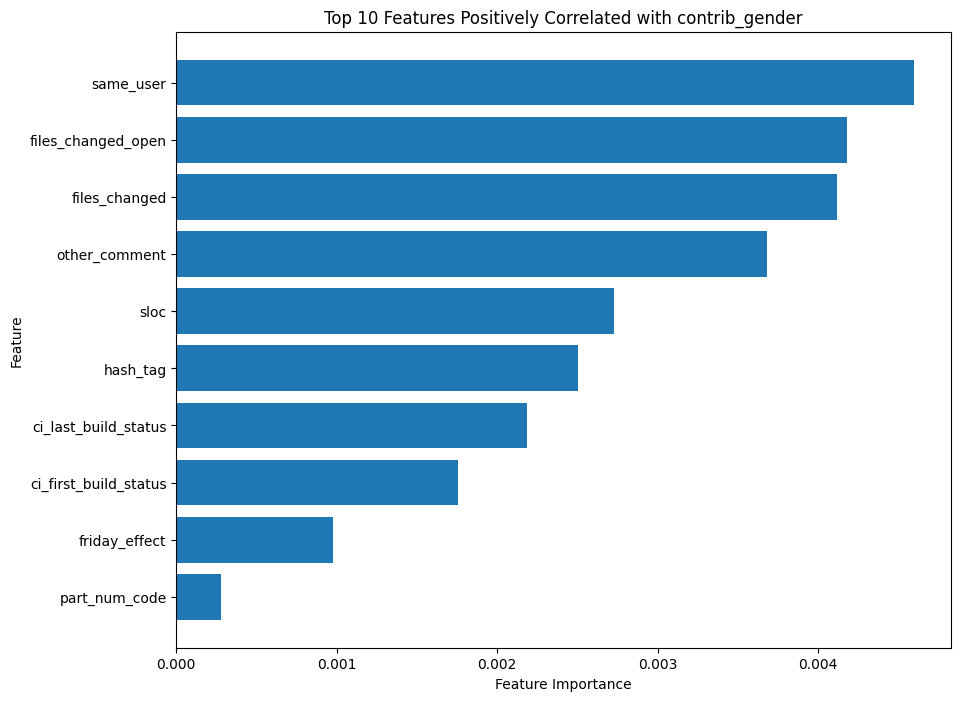

In [73]:
import matplotlib.pyplot as plt

# Calculate correlations using Spearman's rank correlation
correlation_data = rejected_data.drop(['merged_or_not'], axis=1)
corr = correlation_data.corr(method='spearman')
correlation = corr['contrib_gender']

# Sort correlations by value, excluding 'contrib_gender' and negative correlations
sorted_correlations = sorted([(k, v) for k, v in correlation.items() if k != 'contrib_gender' and v > 0], key=lambda x: x[1])

# Get the top 10 features
top_10_features = sorted_correlations[:10]

# Convert the features and their correlations to a DataFrame
df = pd.DataFrame(top_10_features, columns=['Feature', 'Correlation'])

# Sort the DataFrame by correlation
df = df.sort_values('Correlation', ascending=True)

# Plot the correlations
plt.figure(figsize=(10, 8))
plt.barh(df['Feature'], df['Correlation'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features Positively Correlated with contrib_gender')
plt.show()

In [74]:
# find correlation to see which features are important
correlation_data = rejected_data.drop(['merged_or_not'], axis=1)

# Use Spearman's rank correlation coefficient instead of Pearson's
corr = correlation_data.corr(method='spearman')

correlation = corr['contrib_gender']
sorted(correlation.items(), key=lambda x: x[1])

[('perc_contrib_neu_emo', -0.045096281096575014),
 ('pull_request_id', 0.0767021343332833),
 ('mergetime_minutes', nan),
 ('perc_neu_emotion', -0.04317706794869777),
 ('num_comments', -0.03994948577637724),
 ('perc_neg_emotion', -0.0361993829371676),
 ('bug_fix', -0.0319254552763849),
 ('asserts_per_kloc', -0.03166925955684892),
 ('perc_contrib_neg_emo', -0.028166510517095577),
 ('perc_inte_neg_emo', -0.02447773980748406),
 ('commits_on_files_touched_close', -0.022525581136815312),
 ('commits_on_files_touched', -0.02236156211317068),
 ('test_cases_per_kloc', -0.022353620240929),
 ('test_lines_per_kloc', -0.021909759080292374),
 ('watchers', -0.021173757042176902),
 ('ci_latency', -0.02016065071126624),
 ('files_modified_open', -0.019769681303247688),
 ('ci_test_passed', -0.018965514944050826),
 ('code_churn_open', -0.018850013580914513),
 ('churn_deletion', -0.018352348966557547),
 ('churn_deletion_open', -0.01772372795059077),
 ('churn_addition_open', -0.016610422412943665),
 ('src_ch

In [79]:
threshold = 0.002 # moderate relationship or higher
high_correlation = list(filter(lambda x : x[1] >= threshold, sorted(correlation.items(), key=lambda x: x[1])))
high_correlation_feat = list(map(lambda x : x[0], high_correlation))
high_correlation_feat.remove('contrib_gender')
print(high_correlation_feat)

['pull_request_id', 'ci_last_build_status', 'hash_tag', 'sloc', 'other_comment', 'files_changed', 'files_changed_open', 'same_user', 'reopen_or_not', 'reopen_num', 'perc_contrib_pos_emo', 'doc_files', 'doc_files_open', 'requester_succ_rate', 'files_deleted_open', 'added_code', 'num_commits_open', 'files_added', 'other_files', 'perc_external_contribs', 'files_deleted', 'num_commits', 'files_added_open', 'other_files_open', 'team_size', 'first_closer_id', 'last_closer_id']


In [80]:
# get data and clean up data by removing n/a values
USE_CORRELATION = False

if USE_CORRELATION:
    features = high_correlation_feat
    print(features)
else:
    features = rejected_data.columns.tolist()
    # remove the target column
    toremove = ["contrib_gender", "added_code", "mergetime_minutes"]
    for i in toremove:
        features.remove(i)

# features = ['account_creation_days',  'contrib_open',  'part_num_issue',  'perc_neu_emotion',  'num_participants',  'perc_pos_emotion',  'ci_test_passed',  'asserts_per_kloc',  'followers',  'num_issue_comments',  'perc_neg_emotion',  'lifetime_minutes',  'test_inclusion',  'ci_exists',  'acc_commit_num',  'core_member',  'num_comments',  'at_tag',  'pushed_delta',  'part_num_commit',  'first_response_time',  'ci_latency',  'project_age',  'ci_build_num',  'first_pr',  'hash_tag',  'test_churn',  'num_commit_comments',  'comment_conflict',  'prev_pullreqs',  'bug_fix',  'churn_deletion',  'has_comments',  'has_participants',  'reviewer_comment',  'contrib_comment',  'inte_comment',  'has_exchange',  'same_country',  'perc_contrib_neu_emo',  'social_strength',  'agree_diff',  'contrib_rate_author',  'inte_open',  'contrib_follow_integrator',  'extra_diff',  'num_comments_con',  'first_close_minutes',  'perc_inte_pos_emo',  'neur_diff',  'perc_contrib_neg_emo',  'perc_inte_neu_emo',  'cons_diff',  'same_affiliation',  'test_inclusion_open',  'perc_inte_neg_emo',  'num_code_comments_con',  'friday_effect',  'test_churn_open',  'other_comment',  'perc_contrib_pos_emo',  'integrator_availability',  'churn_deletion_open']
rejected_data_cleaned = rejected_data[[*features, 'contrib_gender']].dropna()
X = rejected_data_cleaned[features]
y = rejected_data_cleaned['contrib_gender']

In [81]:
rejected_data_cleaned.shape

(4917, 76)

In [82]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# split into train test val split
train_ratio = 0.70
test_ratio = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_ratio)

# Create a SMOTE object
smote = SMOTE()

# Fit the SMOTE object to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# train the XGBoost classifier model on the balanced training data
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf = clf.fit(X_train_resampled, y_train_resampled)
clf.score(X_test, y_test)

0.8800813008130082

In [83]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

X_array = X.values
y_array = y.values

clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]
    
    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_test)
    
    print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       445
           1       0.20      0.02      0.04        47

    accuracy                           0.90       492
   macro avg       0.55      0.51      0.49       492
weighted avg       0.84      0.90      0.86       492

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       454
           1       0.29      0.05      0.09        38

    accuracy                           0.92       492
   macro avg       0.61      0.52      0.52       492
weighted avg       0.88      0.92      0.89       492

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       446
           1       0.50      0.07      0.12        46

    accuracy                           0.91       492
   macro avg       0.71      0.53      0.53       492
weighted avg       0.87      0.91      0.87       492

              preci

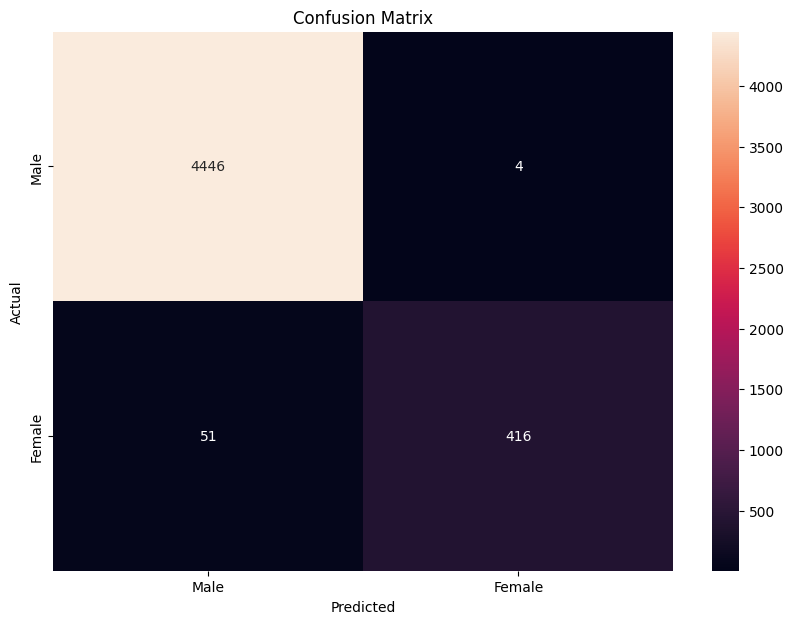

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the model's predictions for the test set
y_pred = clf.predict(X)

# Calculate the confusion matrix
cm = confusion_matrix(y, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Replace the labels
labels = ['Male', 'Female']
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)

plt.show()